# Чем лучше бустить? Тестируем алгоритмы бустинга в бою.

<b>Цель.</b> В этом домашнем задании вам предстоит провести детективную работу и узнать, какой же алгоритм бустинга работает лучше всего (конечно, применительно к конкретной задаче).

<b>Описание/Пошаговая инструкция выполнения домашнего задания:</b>

<b>Часть 1. EDA</b>

* Выберите любой интересующий вас датасет по классификации или регрессии (можно взять из репозитория https://archive.ics.uci.edu/ml/datasets.php, еще неплохие и востребованные на практике варианты - предсказание оттока пользователей https://www.kaggle.com/blastchar/telco-customer-churn или предсказание Customer Livetime Value (CLV или LTV) - https://www.kaggle.com/pankajjsh06/ibm-watson-marketing-customer-value-data
* По выбранному датасету проведите EDA, познакомьтесь с признаками, посмотрите зависимости и т.д.

<b>Часть 2. Preprocessing & Feature Engineering</b>
* Хотя цель этого задания - посмотреть на работу алгоритмов, тем не менее пропускать препроцессинг нельзя :)
* Так что переведите категориальные переменные в уникальные лейблы при помощи LabelEncoder, попробуйте добавить новые переменные и выкинуть лишние и, наконец, разбейте данные на train-test.

<b>Часть 3. Who's the mightiest of them all?</b>
* Постройте 4 варианта градиентного бустинга, используя значения гиперпараметров “из коробки”: реализация из sklearn, XGBoost, CatBoost, LightGBM
* Проверьте качество на отложенной выборке, кто пока лидирует?
* Теперь проведите настройку гиперпараметров моделей на кросс-валидации, можно настраивать только самые основные гиперпараметры - число итераций бустинга, max_features, subsample и т.д.
* Снова проверьте качество уже настроенных моделей. Кто в итоге победил?

# Часть 1. EDA

Для работы взят датасет Telco Customer Churn: https://www.kaggle.com/datasets/blastchar/telco-customer-churn

1. Импортируем основные библиотеки.

In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2. Считываем данные из CSV-файла. Выводим первые 5 строк, чтобы убедиться, что данные считались с локального файла.

In [2]:
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
pd.set_option('display.max_columns', None)
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


3. Посмотрим на количество записей в файле.

In [3]:
df.shape

(7043, 21)

4. Посмотрим, какого типа эти данные:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Видим, что пропущенные значения отсутствуют. Есть категориальные признаки.

Дадим перевод признакам.

| <b>Признак ENG</b>        | <b>Признак RUS</b>                |
| :-:                       | :-:                               |
| customerID	            | Идентификатор клиента             |
| gender	                | пол                               |
| Senior Citizen	        | Пожилой гражданин                 |
| Partner	                | Партнер                           |
| Dependents	            | Иждивенцы                         |
| tenure	                | срок владения                     |
| PhoneService	            | Телефонная связь                  |
| MultipleLines	            | Несколько линий                   |
| InternetService	        | Интернет-связь                    |
| OnlineSecurity	        | Онлайн-безопасность               |
| OnlineBackup	            | Онлайн-резервное копирование      |
| DeviceProtection	        | Защита устройств                  |
| TechSupport	            | Техническая поддержка             |
| StreamingTV	            | Потоковое ТВ                      |
| StreamingMovies	        | Потоковое кино                    |
| Contract	                | Договор                           |
| PaperlessBilling	        | Безбумажное выставление счетов    |
| PaymentMethod	            | Способ оплаты                     |
| MonthlyCharges	        | Ежемесячные платежи               |
| TotalCharges	            | Общая сумма платежей              |
| Churn	                    | отток                             |

Целевая переменая Cham - Отток.

In [5]:
# Просмотр количества уникальных записей для каждого признака
df.apply(lambda x: x.nunique())

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

5. Уберём из датасета признак customerID, который имеет только уникальные значения.

In [6]:
# Удаление признаков
columns_to_drop = ['customerID']
df = df.drop(columns=columns_to_drop, axis=1)

# Вывод обновленного датасета
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


6. Посмотрим на соотношение значений целевой переменной.

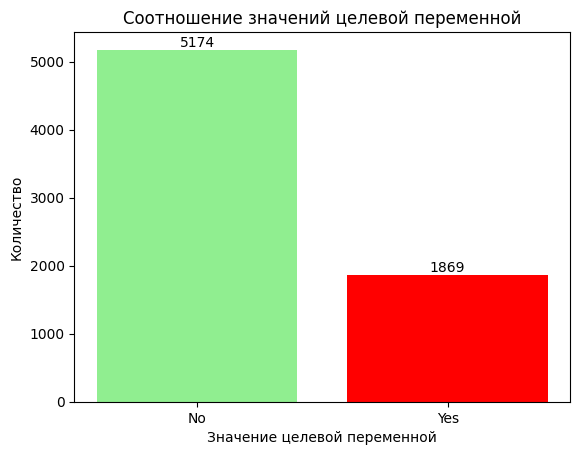

In [7]:
# Создаем столбчатую диаграмму
fig, ax = plt.subplots()
target_value_counts = df['Churn'].value_counts().sort_index()
ax.bar(target_value_counts.index, target_value_counts, color=['lightgreen', 'red'])

# Настройка заголовка и осей
plt.title('Соотношение значений целевой переменной')
plt.xlabel('Значение целевой переменной')
plt.ylabel('Количество')

# Добавим числовые значения на график
for i, value in enumerate(target_value_counts):
    plt.text(i, value, str(value), ha='center', va='bottom')

# Отображаем график
plt.show()

Видим, что число дисбалан в целевой переменной практически в три раза.
</br>1. Это потребует от нас соответсвующего распределения данных при тестировании и обучении.
</br>2. Так же потребуется применять алгоритмы машинного обучения, обладающие встроенной устойчивостью к дисбалансу классов,
такие как алгоритмы градиентного бустинга.
</br>3. Кроме того будем использовать метрики, учитывающие дисбаланс классов, такие как recall, ROC-AUC.

7. Построим диаграммы распределения числовых признаков с использованием числовой переменной для группировки и раскраски данных.

In [8]:
# # Создаем графики с расцветкой 0 - зелёный, 1 - красный, в 2 столбца на всю ширину экрана
# fig, axes = plt.subplots(7, 3, figsize=(24, 24))

# # Создаем гистограмму с прозрачным зеленым цветом
# sns.histplot(data=df, x="gender", hue="Churn", ax=axes[0, 0], palette={"No": 'lightgreen', "Yes": 'red'})
# sns.histplot(data=df, x="SeniorCitizen", hue="Churn", ax=axes[0, 1], palette={"No": 'lightgreen', "Yes": 'red'})
# sns.histplot(data=df, x="Partner", hue="Churn", ax=axes[0, 2], palette={"No": 'lightgreen', "Yes": 'red'})

# sns.histplot(data=df, x="Dependents", hue="Churn", ax=axes[1, 0], palette={"No": 'lightgreen', "Yes": 'red'})
# sns.histplot(data=df, x="tenure", hue="Churn", ax=axes[1, 1], palette={"No": 'lightgreen', "Yes": 'red'})
# sns.histplot(data=df, x="PhoneService", hue="Churn", ax=axes[1, 2], palette={"No": 'lightgreen', "Yes": 'red'})

# sns.histplot(data=df, x="MultipleLines", hue="Churn", ax=axes[2, 0], palette={"No": 'lightgreen', "Yes": 'red'})
# sns.histplot(data=df, x="InternetService", hue="Churn", ax=axes[2, 1], palette={"No": 'lightgreen', "Yes": 'red'})
# sns.histplot(data=df, x="OnlineSecurity", hue="Churn", ax=axes[2, 2], palette={"No": 'lightgreen', "Yes": 'red'})

# sns.histplot(data=df, x="OnlineBackup", hue="Churn", ax=axes[3, 0], palette={"No": 'lightgreen', "Yes": 'red'})
# sns.histplot(data=df, x="DeviceProtection", hue="Churn", ax=axes[3, 1], palette={"No": 'lightgreen', "Yes": 'red'})
# sns.histplot(data=df, x="TechSupport", hue="Churn", ax=axes[3, 2], palette={"No": 'lightgreen', "Yes": 'red'})

# sns.histplot(data=df, x="StreamingTV", hue="Churn", ax=axes[4, 0], palette={"No": 'lightgreen', "Yes": 'red'})
# sns.histplot(data=df, x="StreamingMovies", hue="Churn", ax=axes[4, 1], palette={"No": 'lightgreen', "Yes": 'red'})
# sns.histplot(data=df, x="Contract", hue="Churn", ax=axes[4, 2], palette={"No": 'lightgreen', "Yes": 'red'})

# sns.histplot(data=df, x="PaperlessBilling", hue="Churn", ax=axes[5, 0], palette={"No": 'lightgreen', "Yes": 'red'})
# sns.histplot(data=df, x="PaymentMethod", hue="Churn", ax=axes[5, 1], palette={"No": 'lightgreen', "Yes": 'red'})
# sns.histplot(data=df, x="MonthlyCharges", hue="Churn", ax=axes[5, 2], palette={"No": 'lightgreen', "Yes": 'red'})

# sns.histplot(data=df, x="TotalCharges", hue="Churn", ax=axes[6, 0], palette={"No": 'lightgreen', "Yes": 'red'})

# # Удаляем последний пустой график
# fig.delaxes(axes[6, 1])
# fig.delaxes(axes[6, 2])

# # Отображаем графики
# plt.show()

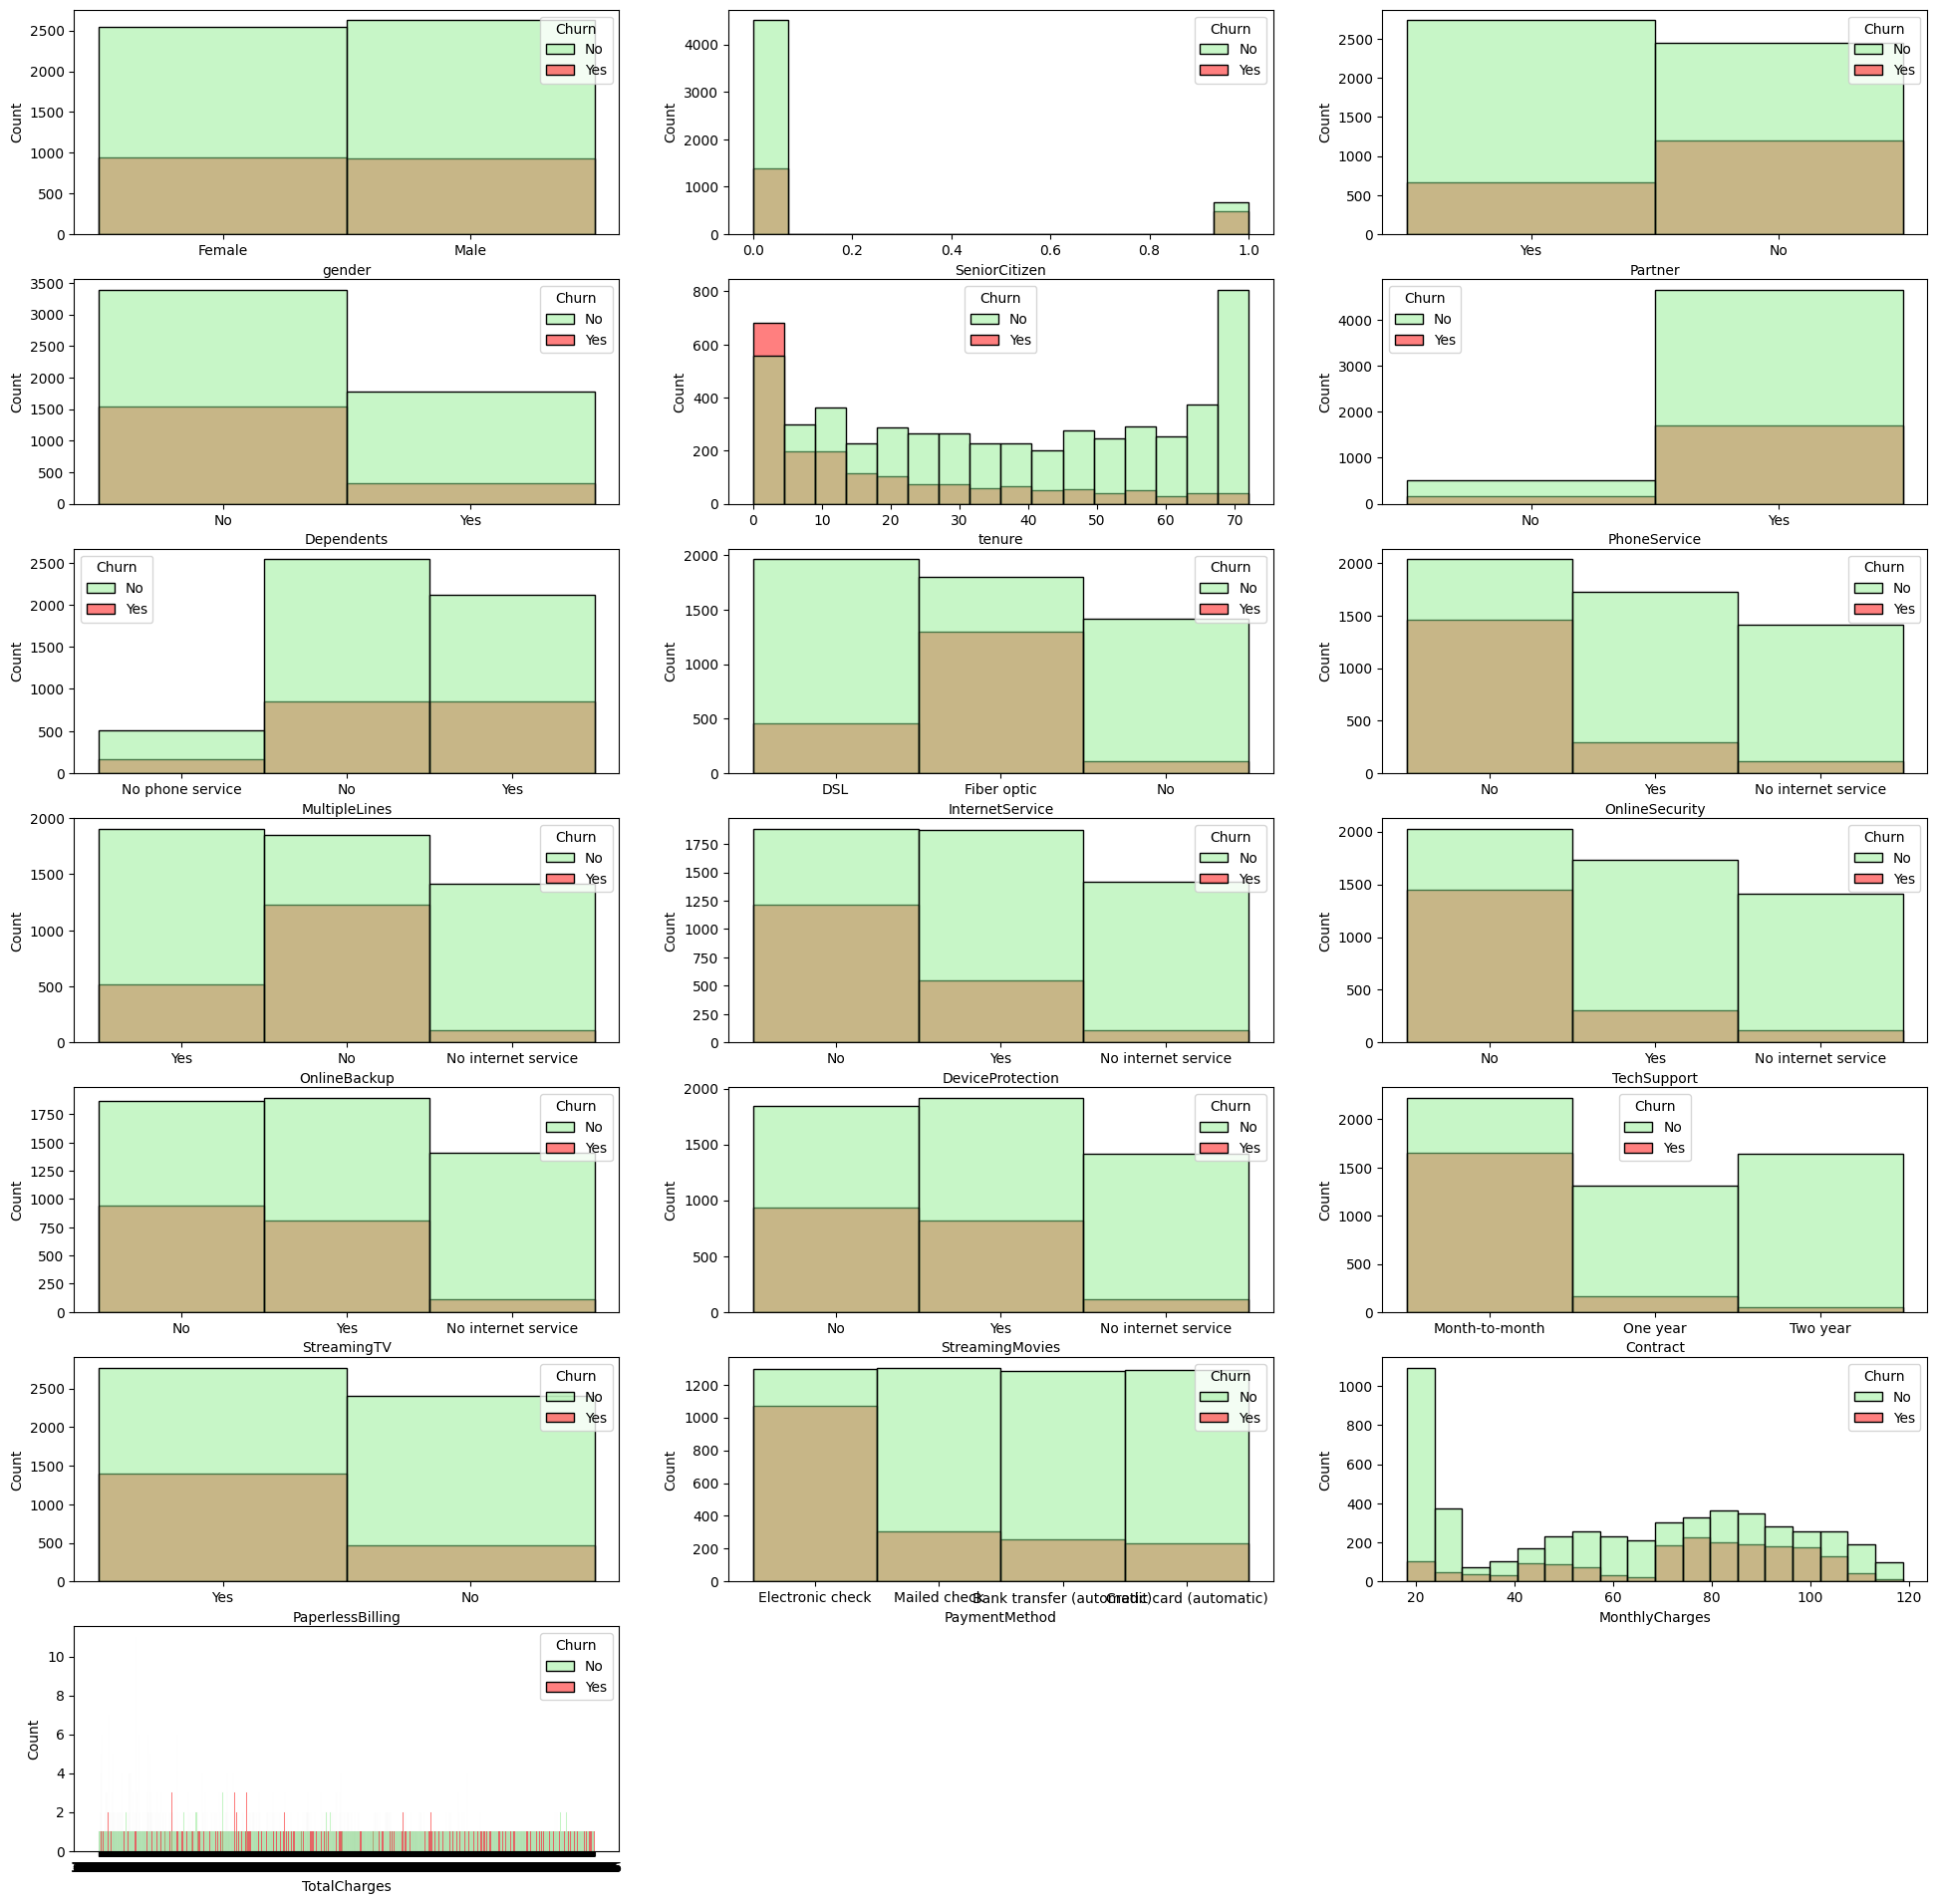

In [9]:
def plot_hist(data, feature_list):
    fig, axes = plt.subplots(7, 3, figsize=(24, 24))
    row = 0
    col = 0
    
    for feature in feature_list:
        sns.histplot(data=data, x=feature, hue="Churn", ax=axes[row, col], palette={"No": 'lightgreen', "Yes": 'red'})
        
        col += 1
        if col == 3:
            col = 0
            row += 1
    
    # Удаляем последний пустой график
    fig.delaxes(axes[6, 1])
    fig.delaxes(axes[6, 2])
    
    # Отображаем графики
    plt.show()

# Список всех признаков для построения гистограмм
feature_list = ["gender", "SeniorCitizen", "Partner", "Dependents", "tenure", 
                "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", 
                "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", 
                "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod", 
                "MonthlyCharges", "TotalCharges"]

# Вызов функции для построения гистограмм
plot_hist(df, feature_list)

<b>Исходя из графиков можно сделать следующий вывод:</b> К оттоку клиентов больше склонны:
 * пожилые лица (SeniorCitizen),
 * лица, не имеющие партнёра (Partner),
 * лица, которые недолго находятся в своей должности (tenure), чем выше срок, тем меньше оттока,
 * лица, имеющие оптоволокно (InternetService),
 * лица, не имеющие Онлайн-безопасность (OnlineSecurity),
 * лица, не имеющие Онлайн-резервное копирование (OnlineBackup),
 * лица, не имеющие Защиту устройств (DeviceProtection),
 * лица, не имеющие Защиту Техническую поддержку (TechSupport),
 * лица, имеющие краткосрочные договоры (Contract),
 * лица, получающие электронный чек (PaymentMethod).

# Часть 2. Preprocessing & Feature Engineering

1. Посмотрим уникальные значения признаков датасета (для уникальных значений менее 3х).

In [10]:
unique_values = {column: df[column].unique() for column in df.columns if len(df[column].unique()) <= 3}
for key, value in unique_values.items():
    print(f'{key} : {value}')

gender : ['Female' 'Male']
SeniorCitizen : [0 1]
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
Churn : ['No' 'Yes']


2. Преобразуем значения признаков, у которых уникальные значения ['Yes', 'No'] в [1, 0].

In [11]:
for column in df.columns:
    unique_values = df[column].unique()
    if len(unique_values) == 2 and 'Yes' in unique_values and 'No' in unique_values:
        df.replace({column: {'Yes': 1, 'No': 0}}, inplace=True)

unique_values = {column: df[column].unique() for column in df.columns if len(df[column].unique()) <= 3}
for key, value in unique_values.items():
    print(f'{key} : {value}')

gender : ['Female' 'Male']
SeniorCitizen : [0 1]
Partner : [1 0]
Dependents : [0 1]
PhoneService : [0 1]
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : [1 0]
Churn : [0 1]


3. Переведём категориальные переменные в уникальные лейблы при помощи LabelEncoder.

In [12]:
from sklearn.preprocessing import LabelEncoder

columns = ['gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 
           'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 
           'StreamingMovies', 'Contract', 'PaymentMethod']

label_encoder = LabelEncoder()

for column in columns:
    df[column] = label_encoder.fit_transform(df[column])

pd.set_option('display.max_columns', None)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,1889.5,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,108.15,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,1840.75,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,151.65,1


4. Уберём TotalCharges, т.к. он имеет более 90% уникальных значений.

In [13]:
# Удаление признаков
columns_to_drop = ['TotalCharges']
df = df.drop(columns=columns_to_drop, axis=1)

# Вывод обновленного датасета
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,Churn
0,0,0,1,0,1,0,1,0,0,2,0,0,0,0,0,1,2,29.85,0
1,1,0,0,0,34,1,0,0,2,0,2,0,0,0,1,0,3,56.95,0
2,1,0,0,0,2,1,0,0,2,2,0,0,0,0,0,1,3,53.85,1
3,1,0,0,0,45,0,1,0,2,0,2,2,0,0,1,0,0,42.30,0
4,0,0,0,0,2,1,0,1,0,0,0,0,0,0,0,1,2,70.70,1


5. Разобъём данные на train-test.

In [14]:
from sklearn.model_selection import train_test_split

# Задаём признаки (X) и целевую переменную (y)
X = df.drop('Churn', axis=1)
y = df['Churn']

# Разделим на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучающая выборка: X_train, y_train
# Тестовая выборка: X_test, y_test

# Часть 3. Who's the mightiest of them all?

* Постройте 4 варианта градиентного бустинга, используя значения гиперпараметров “из коробки”: реализация из sklearn, XGBoost, CatBoost, LightGBM
* Проверьте качество на отложенной выборке, кто пока лидирует?

In [15]:
# !pip install catboost

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import catboost
import lightgbm as lgb
from sklearn.metrics import recall_score, roc_auc_score

# Обучение и оценка GradientBoostingClassifier по recall и ROC-AUC
gb_clf = GradientBoostingClassifier()
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_recall = recall_score(y_test, gb_pred)
gb_roc_auc = roc_auc_score(y_test, gb_pred)

# Обучение и оценка XGBoost по recall и ROC-AUC
xgb_clf = xgb.XGBClassifier()
xgb_clf.fit(X_train, y_train)
xgb_pred = xgb_clf.predict(X_test)
xgb_recall = recall_score(y_test, xgb_pred)
xgb_roc_auc = roc_auc_score(y_test, xgb_pred)

# Обучение и оценка CatBoost по recall и ROC-AUC
cat_clf = catboost.CatBoostClassifier(verbose=False)
cat_clf.fit(X_train, y_train)
cat_pred = cat_clf.predict(X_test)
cat_recall = recall_score(y_test, cat_pred)
cat_roc_auc = roc_auc_score(y_test, cat_pred)

# Обучение и оценка LightGBM по recall и ROC-AUC
lgb_clf = lgb.LGBMClassifier(verbosity=-1)
lgb_clf.fit(X_train, y_train)
lgb_pred = lgb_clf.predict(X_test)
lgb_recall = recall_score(y_test, lgb_pred)
lgb_roc_auc = roc_auc_score(y_test, lgb_pred)

# Создание списка для хранения результатов
results = []

# Оценка и сохранение результатов для каждой модели
models = {
    "GradientBoostingClassifier": gb_clf,
    "XGBoost": xgb_clf,
    "CatBoost": cat_clf,
    "LightGBM": lgb_clf
}

for name, model in models.items():
    pred = model.predict(X_test)
    recall = recall_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    results.append({"Model": name, "Recall": recall, "ROC-AUC": roc_auc})

# Создание DataFrame из списка результатов
results_df = pd.DataFrame(results)

# Вывод результатов в виде таблицы
print(results_df)

                        Model    Recall   ROC-AUC
0  GradientBoostingClassifier  0.541555  0.724445
1                     XGBoost  0.514745  0.696562
2                    CatBoost  0.525469  0.713507
3                    LightGBM  0.536193  0.714042


Для задач классификации, чем выше значения Recall и ROC-AUC, тем лучше модель способна обнаруживать положительные примеры и разделять классы. Таким образом победил <b>GradientBoostingClassifier</b>.

* Теперь проведите настройку гиперпараметров моделей на кросс-валидации, можно настраивать только самые основные гиперпараметры - число итераций бустинга, max_features, subsample и т.д.
* Снова проверьте качество уже настроенных моделей. Кто в итоге победил?

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
import catboost
import lightgbm as lgb
from sklearn.metrics import recall_score, roc_auc_score

# Определение параметров для настройки
gb_params = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2', None],
    'subsample': [0.8, 0.9, 1.0]
}

xgb_params = {
    'n_estimators': [50, 100, 200],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'subsample': [0.8, 0.9, 1.0]
}

cat_params = {
    'iterations': [50, 100, 200],
    'colsample_bylevel': [0.8, 0.9, 1.0],
    'subsample': [0.8, 0.9, 1.0]
}

lgb_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 0.9, 1.0]
}

# Применение GridSearchCV для настройки гиперпараметров
def tune_model(model, params):
    grid_search = GridSearchCV(model, param_grid=params, scoring='roc_auc', cv=3)
    grid_search.fit(X_train, y_train)
    return grid_search

# Настройка каждой модели
gb_clf_tuned = tune_model(GradientBoostingClassifier(), gb_params)
xgb_clf_tuned = tune_model(xgb.XGBClassifier(), xgb_params)
cat_clf_tuned = tune_model(catboost.CatBoostClassifier(verbose=False), cat_params)
lgb_clf_tuned = tune_model(lgb.LGBMClassifier(verbosity=-1), lgb_params)

# Оценка и сохранение результатов для каждой модели
models_tuned = {
    "GradientBoostingClassifier": gb_clf_tuned,
    "XGBoost": xgb_clf_tuned,
    "CatBoost": cat_clf_tuned,
    "LightGBM": lgb_clf_tuned
}

results_tuned = []

for name, model in models_tuned.items():
    pred = model.predict(X_test)
    recall = recall_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred)
    results_tuned.append({"Model": name, "Recall": recall, "ROC-AUC": roc_auc})

# Создание DataFrame из списка настроенных результатов
results_tuned_df = pd.DataFrame(results_tuned)

# Вывод настроенных результатов в виде таблицы
print(results_tuned_df)

                        Model    Recall   ROC-AUC
0  GradientBoostingClassifier  0.541555  0.724445
1                     XGBoost  0.530831  0.713775
2                    CatBoost  0.530831  0.717153
3                    LightGBM  0.506702  0.711363


Снова победил <b>GradientBoostingClassifier</b>.